In [2]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0') # some other variable would need to be set with the gpuarray backend

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [3]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy import misc
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import theano
import theano.tensor as T

import src.pyFWRF as prf
import src.pyNumpyUtility as pnu
from   src.pyFWRF import FWRF_model, fpX

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"

print "Time Stamp: %s" % timestamp

Time Stamp: May-09-2017_1357


In [5]:
def save_stuff(save_to_this_file, data_objects_dict):
    failed = []
    with h5py.File(save_to_this_file+'.h5py', 'w') as hf:
        for k,v in data_objects_dict.iteritems():
            try:
                hf.create_dataset(k,data=v)
                print 'saved %s in h5py file' %(k)
            except:
                failed.append(k)
                print 'failed to save %s as h5py. will try pickle' %(k)   
    for k in failed:
        with open(save_to_this_file+'_'+'%s.pkl' %(k), 'w') as pkl:
            try:
                pickle.dump(data_objects_dict[k],pkl)
                print 'saved %s as pkl' %(k)
            except:
                print 'failed to save %s in any format. lost.' %(k)
                
def display_candidate_loss(scores, nx, ny, ns):
    dis_y = ns // 3 if ns%3==0 else ns//3+1
    s = scores.reshape((nx, ny, ns)).transpose((1,0,2))[::-1,:,:] ## The transpose and flip is just so that the candidate 
    #coordinate maatch the normal cartesian coordinate of the rf position when viewed through imshow.
    idxs = np.unravel_index(np.argmin(s), (nx,ny,ns))
    best = plt.Circle((idxs[1], idxs[0]), 0.5, color='r', fill=False, lw=2)
    
    fig = plt.figure(figsize=(15, 5*dis_y))
    smin = np.min(s)
    smax = np.max(s)
    print "score range = (%f, %f)" % (smin, smax)
    for i in range(ns):
        plt.subplot(dis_y, 3, i+1)
        plt.imshow(s[:,:,i], interpolation='None')
        plt.title('sigma canditate = %d' % i)
        plt.clim(smin, smax)
        if(idxs[2]==i):
            ax = plt.gca()
            ax.add_artist(best)
    return fig

# 1a) Load the image dataset (the images that were presented to the subject for which we have voxel data)

## Load vim-1 dataset

In [6]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

In [7]:
stimuli_lowrez = sio.loadmat(dataset_dir+"Stimuli.mat") ### this loads a low-rez version of the stimuli
print stimuli_lowrez.keys()

trn_size = len(stimuli_lowrez["stimTrn"])
val_size = len(stimuli_lowrez["stimVal"])
data_size = trn_size + val_size

print "trn: %d, val: %d" % (trn_size, val_size)

['seqTrn', '__header__', '__globals__', 'stimVal', 'seqVal', 'stimTrn', '__version__']
trn: 1750, val: 120


In [8]:
train_stim_files = glob(dataset_dir+"Stimuli_Trn_FullRes*.mat")
val_stim_file = dataset_dir+"Stimuli_Val_FullRes.mat"

In [9]:
##load validation stim
val_h5 = h5py.File(val_stim_file,'r')
val_stimuli_hirez = np.transpose(val_h5['stimVal'][:],[2,1,0]).astype(fpX)
val_h5.close()

##allocate memory for stim
hirez_resolution = val_stimuli_hirez.shape[1:3]
trn_stimuli_hirez = np.zeros((trn_size,)+hirez_resolution ,dtype=fpX)

##load training stim
cnt = 0
for sl in sorted(train_stim_files):
    this_h5 = h5py.File(sl,'r')
    this_train_stim = this_h5['stimTrn']
    this_num_stim = this_train_stim.shape[-1]
    trn_stimuli_hirez[cnt:cnt+this_num_stim,:,:] = np.transpose(this_train_stim[:],[2,1,0])
    cnt += this_num_stim
    this_h5.close()

## Convert to resolution of the network input

In [10]:
npx = 227
npc = 1

#trn_source = stimuli_lowrez["stimTrn"]
#val_source = stimuli_lowrez["stimVal"]
trn_source = trn_stimuli_hirez
val_source = val_stimuli_hirez

stim_data = np.ndarray(shape=(data_size, npx, npx, npc), dtype=fpX)

for i,rawim in enumerate(trn_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)               
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    
    stim_data[i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)

for i,rawim in enumerate(val_source):
    rawmin, rawmax = np.min(rawim), np.max(rawim)
    sim = (rawim - rawmin) * 255 / (rawmax - rawmin)         
    im = pim.fromarray(sim, mode='F').resize((npx, npx), resample=pim.BILINEAR).convert('RGB')
    stim_data[trn_size+i,...] = np.mean(np.asarray(im), axis=2, keepdims=True)
        
stim_data = np.transpose((stim_data - 128) / 128, (0,3,1,2))
print "Data shape = %s" % (stim_data.shape,)

trn_stim_data = stim_data[:trn_size]
val_stim_data = stim_data[trn_size:]

Data shape = (1870, 1, 227, 227)


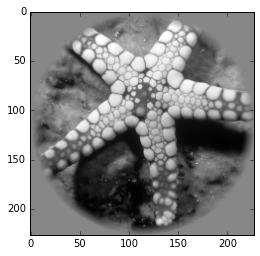

In [11]:
plt.imshow(trn_stim_data[5,0,:,:], cmap='gray')

# 1b) Load the corresponding voxel data

In [12]:
voxelset = h5py.File(dataset_dir+"EstimatedResponses.mat")
print voxelset.keys()

[u'dataTrnS1', u'dataTrnS2', u'dataValS1', u'dataValS2', u'roiS1', u'roiS2', u'voxIdxS1', u'voxIdxS2']


In [13]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [14]:
voxeldata = np.concatenate([voxelset['dataTrn%s'%subject], voxelset['dataVal%s'%subject]], axis=0).astype(dtype=fpX)
voxelroi = voxelset['roi%s'%subject]
voxelidx = voxelset['voxIdx%s'%subject]
print voxeldata.shape

voxelNanMask = ~np.isnan(voxeldata).any(axis=0)
nv = np.sum(voxelNanMask)
print "%d voxels contain valid values for all images" % nv

(1870, 25915)
22701 voxels contain valid values for all images


In [15]:
voxel_data = voxeldata[:, voxelNanMask].astype(dtype=fpX)
voxelROI  = voxelroi[:, voxelNanMask]
voxelIDX  = voxelidx[:, voxelNanMask]
print voxel_data.shape

trn_voxel_data = voxel_data[:trn_size]
val_voxel_data = voxel_data[trn_size:]

(1870, 22701)


### (Optional) Restricted set of voxels

In [16]:
nv = 1000
start_v = (3566 // nv) * nv
trn_voxel_data = trn_voxel_data[:, start_v:start_v+nv]
val_voxel_data = val_voxel_data[:, start_v:start_v+nv]

# 0) Create the feature space and generate the feature maps for the dataset

In [17]:
model_name = 'gabor'
from gaborizer.src.gabor_feature_dictionaries import gabor_feature_maps

In [18]:
n_orientations = 4
deg_per_stimulus = 20.
lowest_sp_freq = .25 ##cyc/deg
highest_sp_freq = 6. #4.664387 #6.25
num_sp_freq = 12
pix_per_cycle = 3.13333333
complex_cell = True

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 48


In [22]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle, complex_cell=complex_cell,
                         diams_per_filter = 4,
                         cycles_per_radius = 1.0)

In [23]:
print gfm.filter_stack.shape
gfm.gbr_table.head(17)

(48, 1, 25, 25)


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,8,32.000000,15.666667,25,4.000000,0.000000
1,0.333744,8,23.970452,20.914638,25,2.996307,0.000000
2,0.445541,8,17.955706,27.920558,25,2.244463,0.000000
3,0.594787,8,13.450200,37.273300,25,1.681275,0.000000
4,0.794027,8,10.075230,49.758995,25,1.259404,0.000000
5,1.060007,8,7.547120,66.427109,25,0.943390,0.000000
6,1.415085,8,5.653371,88.678655,25,0.706671,0.000000
7,1.889106,8,4.234808,118.383956,25,0.529351,0.000000
8,2.521912,8,3.172196,158.039846,25,0.396524,0.000000
9,3.366695,8,2.376218,210.979542,25,0.297027,0.000000


float64
(48, 1, 25, 25)


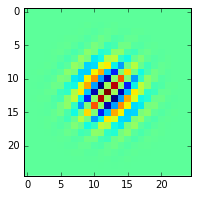

In [24]:
print np.real(gfm.filter_stack).dtype

#complex fs = np.stack([np.real(gfm.filter_stack), np.imag(gfm.filter_stack), np.zeros(shape=gfm.filter_stack.shape)]).transpose([1,2,3,4,0])
fs = np.real(gfm.filter_stack)
print fs.shape 
fig=plt.figure(figsize=(3,3))
plt.imshow(fs[15, 0, :, :], interpolation='None')

In [25]:
#filename = output_dir + "gabor_example.png"
#fig.patch.set_alpha(0.)
#fig.savefig(filename)
#plt.close()

In [26]:
##construct the model space
feat_dict = gfm.create_feature_maps(stim_data)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.241925 s.
feature 1 took 0.256558 s.
feature 2 took 0.293789 s.
feature 3 took 0.386766 s.
feature 4 took 0.604273 s.
feature 5 took 1.012810 s.
feature 6 took 1.844108 s.
feature 7 took 3.343944 s.
feature 8 took 6.215060 s.
feature 9 took 11.463908 s.
feature 10 took 21.067178 s.
feature 11 took 38.306513 s.
feature 12 took 0.227065 s.
feature 13 took 0.248764 s.
feature 14 took 0.291496 s.
feature 15 took 0.385670 s.
feature 16 took 0.608182 s.
feature 17 took 1.014873 s.
feature 18 took 1.845585 s.
feature 19 took 3.342613 s.
feature 20 took 6.214982 s.
feature 21 took 11.464905 s.
feature 22 took 21.051140 s.
feature 23 took 38.251237 s.
feature 24 took 0.224964 s.
feature 25 took 0.249712 s.
feature 26 took 0.291695 s.
feature 27 took 0.384084 s.
feature 28 took 0.605685 s.
feature 29 took 1.013930 s.
feature 30 took 1.842666 s.
feature 31 took 3.336957 s.
feature 32 took 6.208608 s.
feature 33 took 11.

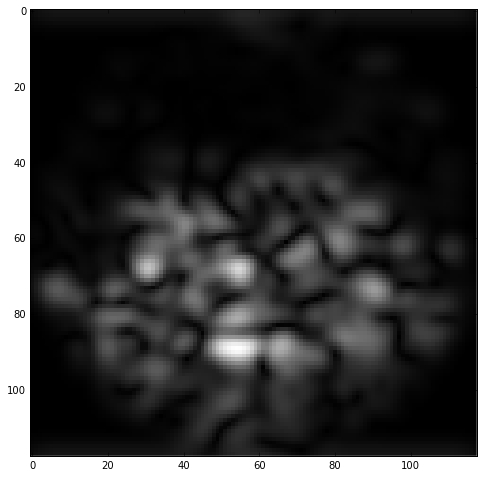

In [27]:
fmn = 7
fig=plt.figure(figsize=(8,8))
plt.imshow(feat_dict[fmn][3,0,:,:], cmap='gray', interpolation='None')

## Concatenate feature maps of the same resolution

In [28]:
fmap_rez = []
for k in feat_dict.keys():
    fmap_rez += [feat_dict[k].shape[2],]
resolutions = np.unique(fmap_rez)
print resolutions
## we should concatenate those that have the same resolutions

[ 16  21  28  37  50  66  89 118 158 211 282 376]


In [29]:
#activation function applied to the convolved images.
log_act_func = lambda x: np.log(1+np.sqrt(x))

# concatenate and sort as list
fmaps_res_count = len(resolutions)
fmaps_count = 0
fmaps = []
for r in range(fmaps_res_count):
    fmaps += [[],] #needs to be set manually
fmaps_sizes = []

for k in feat_dict.keys():
    # determine which resolution idx this map belongs to
    ridx = np.argmax(resolutions==feat_dict[k].shape[2])
    if len(fmaps[ridx])==0:
        fmaps[ridx] = log_act_func(feat_dict[k].astype(fpX))
    else:
        fmaps[ridx] = np.concatenate((fmaps[ridx], log_act_func(feat_dict[k].astype(fpX))), axis=1)       
    fmaps_count += 1
    
for fmap in fmaps:
    fmaps_sizes += [fmap.shape]
print fmaps_sizes
print "total fmaps = %d" % fmaps_count

[(1870, 4, 16, 16), (1870, 4, 21, 21), (1870, 4, 28, 28), (1870, 4, 37, 37), (1870, 4, 50, 50), (1870, 4, 66, 66), (1870, 4, 89, 89), (1870, 4, 118, 118), (1870, 4, 158, 158), (1870, 4, 211, 211), (1870, 4, 282, 282), (1870, 4, 376, 376)]
total fmaps = 48


In [30]:
# aliases
nf = fmaps_count

# make sure we are using float32
print fmaps[0].dtype

float32


In [31]:
del feat_dict

# 2) MODELS

## Define the inputs
We can either connect the feature maps of the network directly or some precomputed values provided in a suitable list

In [32]:
#feature maps symbolic variables
_fmaps = []
for r in range(fmaps_res_count):
    _fmaps += [T.tensor4(),] # note this has to be done explicitely, we can't just replicate the tensor object
_invar = _fmaps
# vs.
#_fmaps = [L.get_output(fm, deterministic=True) for fm in _aux]
#_invar = [X,]

## Define the search parameters

In [33]:
lx = ly = 20.
nx = ny = 26
smin, smax = 0.5, 8.
ns = 12

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [prf.linspace(nx), prf.linspace(ny), prf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX), np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])



G = 8112

range x
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range y
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range s
[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


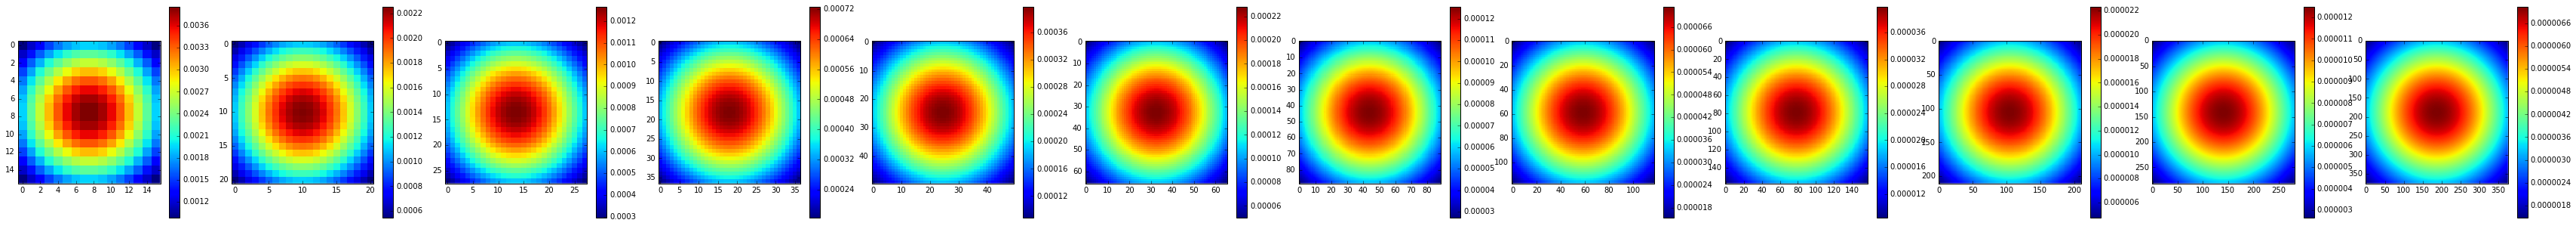

In [34]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print sigmas

ith_rf_size = 11
n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None')
    plt.colorbar()

(0, 10)

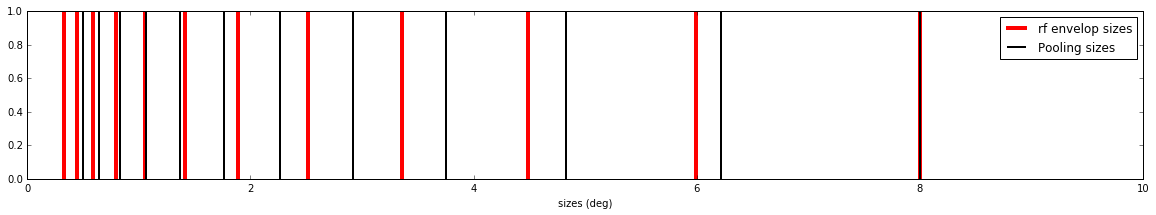

In [35]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
env = 2. / np.logspace(np.log10(lowest_sp_freq),np.log10(highest_sp_freq), num_sp_freq)

fig_1 = plt.figure(figsize=(20,3))
plt.vlines(env, 0., 1., lw=4, color='r', label='rf envelop sizes')
plt.vlines(sigmas, 0., 1., lw=2, color='k', label='Pooling sizes')
#plt.xscale('log')
plt.xlabel('sizes (deg)')
plt.legend()
plt.xlim([0, 10])

## Define the model
This model needs to be batched at different stages

In [36]:
fwrf = FWRF_model(_fmaps, fmaps_sizes, _invar, fmaps_sizes,
    batches_p=(500, ny*nx), batches_o=(200, 1000, 2*ny*nx), batches_t=(500, 2*ny*nx),\
    view_angle=lx, verbose=True)

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 676, 16, 16)
> feature map candidates 1 with shape (1, 676, 21, 21)
> feature map candidates 2 with shape (1, 676, 28, 28)
> feature map candidates 3 with shape (1, 676, 37, 37)
> feature map candidates 4 with shape (1, 676, 50, 50)
> feature map candidates 5 with shape (1, 676, 66, 66)
> feature map candidates 6 with shape (1, 676, 89, 89)
> feature map candidates 7 with shape (1, 676, 118, 118)
> feature map candidates 8 with shape (1, 676, 158, 158)
> feature map candidates 9 with shape (1, 676, 211, 211)
> feature map candidates 10 with shape (1, 676, 282, 282)
> feature map candidates 11 with shape (1, 676, 376, 376)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 830.2 Mb of memory (VRAM and RAM)


Layer	: <lasagne.layers.input.InputLayer object at 0x7fbf235cf590>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.pyFWRF.svFWRFLayer 

## Precompute and save the modelspace tensor

In [38]:
mst_data = fwrf.precompute_mst_data(fmaps, sharedModel_specs, verbose=True, dry_run=False, zscore=True, trn_size=trn_size, epsilon=1e-3)


>> Storing the full modelspace tensor will require approx 2.713Gb of RAM!
>> Will be divided in chunks of 0.452Gb of VRAM!

Precomputing mst candidate responses...


100%|██████████| 12/12 [02:27<00:00, 12.23s/it]

8112 mst candidate responses took 147.312s @ 55.067 models/s
Z-scoring modelspace tensor...



12it [00:10,  1.18it/s]


In [39]:
print mst_data.shape
print np.amin(mst_data), np.amax(mst_data)

(1870, 48, 1, 8112)
-7.56205 9.55846


In [40]:
trn_mst_data = mst_data[:trn_size]
val_mst_data = mst_data[trn_size:]

## Run the models

In [41]:
val_scores, best_scores, best_abs_models, best_rel_models, best_params, best_avg, best_std = fwrf.shared_model_training(\
    trn_mst_data, trn_voxel_data, sharedModel_specs, voxelParams,\
    val_test_size=350, lr=1e-3, l2=0., num_epochs=20, output_val_scores=True, verbose=True, dry_run=False)


Voxel-Candidates model optimization...
1 voxel batches of size 1000 with residual 0
6 candidate batches of size 1352 with residual 0
for 8112000 voxelmodel fits.


0it [00:00, ?it/s]


  Voxel 0:1000 of 1000, Candidate 0:1352 of 8112
    validation <loss>: 0.005684
    validation <loss>: 0.005682
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    validation <loss>: 0.005683
    20 Epoch for 1352000 voxelmodels took 72.750s @ 18584.130 voxelmodels/s

  Voxel 0:1000 of 1000, Candidate 1352:2704 of 8112
    validation <loss>: 0.005682
    validation <loss>: 0.005680
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>

1it [07:18, 438.62s/it]


---------------------------------------------------------------------
20 Epoch for 8112000 voxelmodels took 438.620s @ 18494.368 voxelmodels/s


[ 2.69230771  8.07692337  0.5       ]
score range = (0.003919, 0.005397)


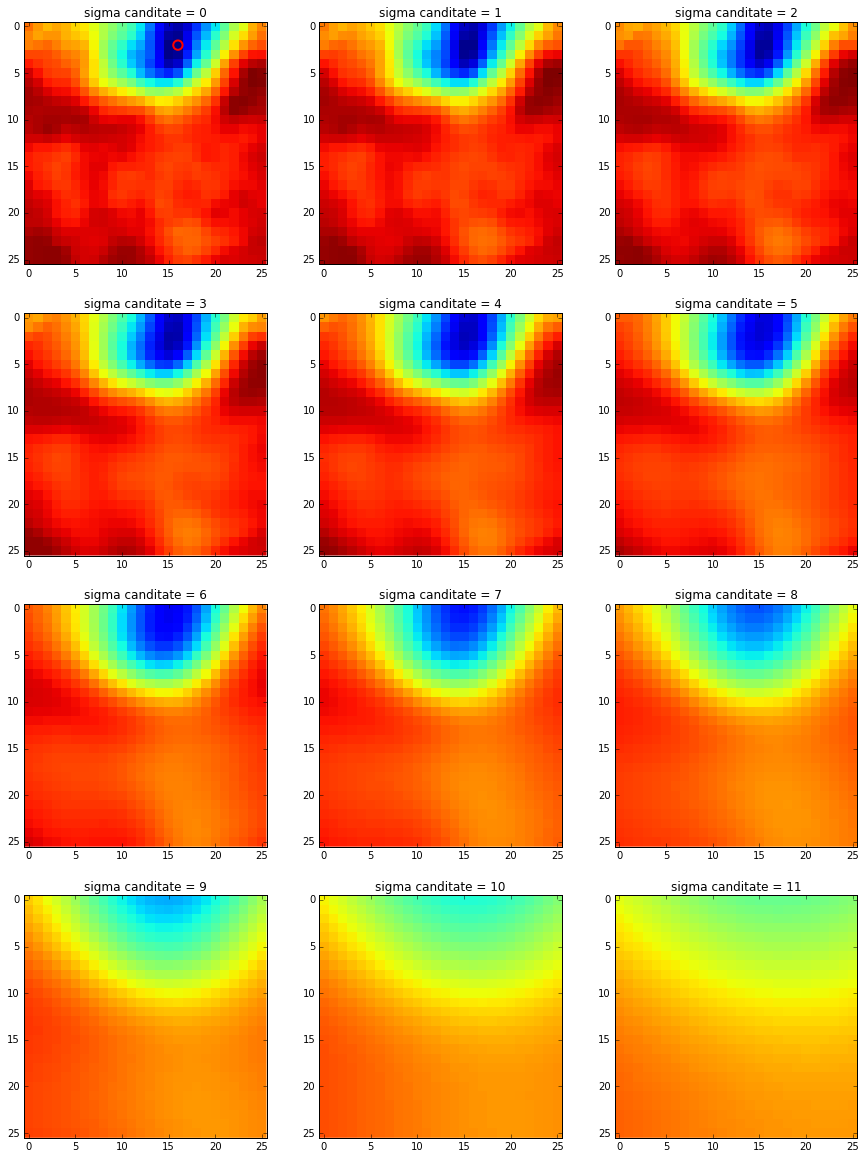

In [42]:
vidx = 566
print best_abs_models[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

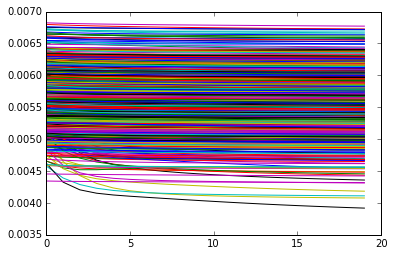

In [43]:
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_rel_models[v]])

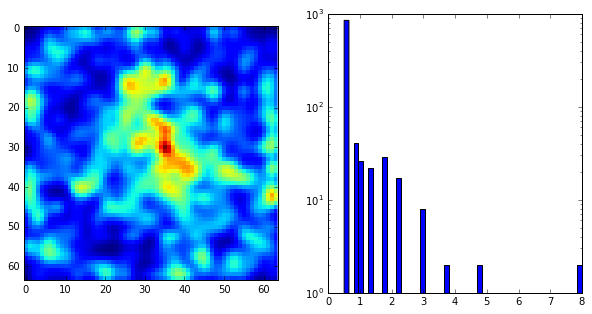

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_abs_models[:,0], best_abs_models[:,1], best_abs_models[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None')
plt.subplot(1,2,2)
_=plt.hist(best_abs_models[:,2], bins=50)
plt.yscale('log')

# Test the models for validation CC

In [46]:
val_pred, val_cc = fwrf.validate_models(val_mst_data, val_voxel_data, best_rel_models, best_params)

0 voxel batches of size 1352 with residual 1000


1it [00:00, 10.90it/s]


argmax cc = 566
max cc = 0.740256
sum(cc>0.2) = 140


(-0.4, 0.9)

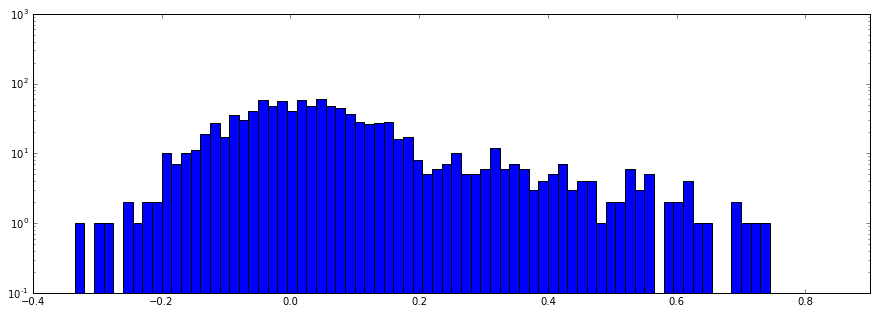

In [47]:
print "argmax cc = %d" % np.argmax(val_cc)
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(15,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

[[ 1.        0.740256]
 [ 0.740256  1.      ]]


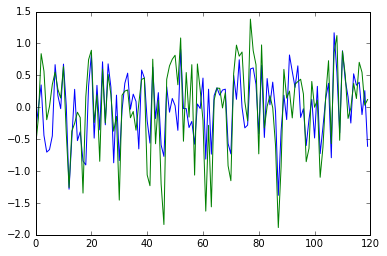

In [48]:
plt.plot(val_pred[:,vidx])
plt.plot(val_voxel_data[:,vidx])

print np.corrcoef(val_pred[:,vidx], val_voxel_data[:,vidx])

In [ ]:
***

In [40]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes,      
             'scores': best_scores,
             'models': best_abs_models,
             'params': best_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/fwrf-master/output/fwrf_S1_Mar-24-2017_1455_data.pkl


In [41]:
#data_file = open(output_dir + "fwrf_model_S1_Feb-17-2017_1812.pkl", 'rb')
#data_value = pickle.load(data_file)
#data_file.close()

# Split accuracy by layer and roi

In [42]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


In [43]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_params[0][:, partitions[l]:partitions[l+1]]
    partition_params[1][:] = best_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.validate_models(val_mst_data, val_voxel_data, best_rel_models, partition_params)

16 voxel batches of size 1352 with residual 1069


17it [00:01,  8.69it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.81it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.80it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.59it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.71it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.68it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.86it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.76it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.74it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.87it/s]

16 voxel batches of size 1352 with residual 1069



17it [00:01,  9.75it/s]


In [44]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [45]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [46]:
nROI = int(np.max(voxelROI))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxelROI.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

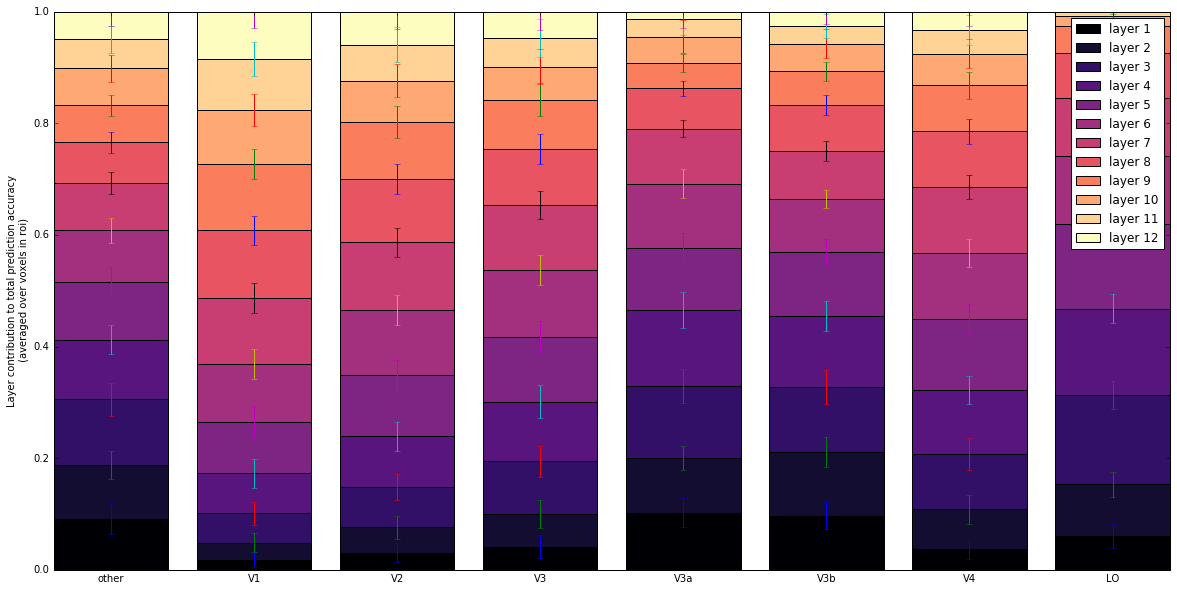

In [47]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')